## Import libraries

In [1]:
import os
from datetime import datetime, date, timedelta
import pandas as pd
import ee

## User inputs

In [5]:
from cropengine.models import get_available_models
from cropengine.crop import get_available_crops, get_available_crop_varieties

# Location
latitude = 52.53
longitude = 14.12

# Crop information
campaign_start_date = '2006-01-01'
crop_start_date = "2006-04-05"
crop_start_type = 'emergence'

crop_end_date = "2006-10-20"
crop_end_type = 'harvest'
campaign_end_date = '2007-01-01'

max_duration = 300

# Other inputs
# Get the available model info (**To be displayed in the dashboard)
models_info = get_available_models()
model = 'Wofost72_WLP_CWB' # User can select from 'models_info' dropdown

crops_info = get_available_crops(model)
crop_name = 'sugarbeet' # User can select from 'crops_info' dropdown

crop_varieties_info = get_available_crop_varieties(model, crop_name) # User can select from 'crop_varieties_info' dropdown
crop_variety = 'Sugarbeet_601' # User can select from 'crop_varieties_info' dropdown

## Create workspace directory

In [6]:
workspace_dir = os.path.join('.', 'workspace') # To be decided by Jahid
os.makedirs(workspace_dir, exist_ok=True)

## Data and parameters preparation

### Weather

In [7]:

from cropengine.weather import GEEWeatherDataProvider

# ee.Authenticate()
# Prepare weather data for a specific point
from datetime import datetime, timedelta

def make_inclusive(end_date_str: str) -> str:
    """Convert string to date, add 1 day, return string."""
    d = datetime.strptime(end_date_str, "%Y-%m-%d").date()
    d_inc = d + timedelta(days=1)
    return d_inc.strftime("%Y-%m-%d")

campaign_end_date_inclusive = make_inclusive(campaign_end_date)
meteo_data = GEEWeatherDataProvider(
    start_date=campaign_start_date, 
    end_date=campaign_end_date_inclusive, 
    latitude=latitude, 
    longitude=longitude, 
    filepath=os.path.join(workspace_dir, 'meteo.xlsx')
)
meteo_data.save_weather_excel()

GEE not initialized. Attempting initialization...
GEE Initialized successfully.
File saved successfully to ./workspace/meteo.xlsx


### Soil

In [8]:
from cropengine.soil import IsricSoilDataProvider, WOFOSTSoilParameterProvider

# Prepare soil data for a specific point
soil_data = IsricSoilDataProvider(
    latitude=latitude, 
    longitude=longitude, 
    depths='0-5cm',
    values=['mean'],
    filepath=os.path.join(workspace_dir, 'soil.csv')
)
# soil_data = soil_data.get_data()
soil_data = pd.read_csv("/beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/workspace/soil.csv")
soil_data = soil_data[soil_data['metric']=='mean']

# Extract soil parameters from the soil data 
soil_params_provider = WOFOSTSoilParameterProvider(soil_data)
soil_params = soil_params_provider.get_params()

In [ ]:
soil_params_info = soil_params_provider.param_metadata # User can change parameters' value from 'soil_params_info' table
soil_params_info = pd.DataFrame(soil_params_info).sort_values(by='parameter').reset_index(drop=True)
print(soil_params_info.shape)
soil_params_info

(46, 4)


,parameter,description,unit,value
0,A0SOM,Initial age of soil organic material,year,None
1,BG_N_SUPPLY,Background supply of N through atmospheric dep...,kg/ha/day,None
2,CNRatioBio,C:N ratio of microbial biomass,kg C kg-1 N,None
3,CNRatioSOMI,Initial C:N ratio of soil organic matter,kg C kg-1 N,8.213
4,CONDfromPF,Table function of the 10-base logarithm of the...,log10(cm water d-1),"[-1.0, 1.672, 1.0, 1.672, 1.3, 1.672, 1.491, 1..."
5,CRAIRC,Critical air content for aeration for root system,m3 air m-3 soil,0.05
6,FASDIS,Fraction of assimilation to dissimilation,-,None
7,FSOMI,Initial fraction of soil organic matter in soil,kg OM kg-1 soil,0.092
8,IFUNRN,Indicates whether non-infiltrating fraction of...,-,None
9,IVINF,Infiltration limiter,-,None


### Site

In [10]:
from cropengine.site import WOFOSTSiteParametersProvider

# Extract site parameters
site_params_provider = WOFOSTSiteParametersProvider(model, WAV=10)
site_params = site_params_provider.get_params()

In [11]:
site_params_info = site_params_provider.param_metadata # User can change parameters' value from 'site_params_info' table
site_params_info = pd.DataFrame(site_params_info).sort_values(by='parameter').reset_index(drop=True)
print(site_params_info.shape)
site_params_info

(6, 7)


,parameter,required,default,range,type,description,unit
0,IFUNRN,False,0.0,"[0, 1]",int,Indicates whether non-infiltrating fraction of...,-
1,NOTINF,False,0.0,"[0.0, 1.0]",float,Maximum fraction of rain not-infiltrating into...,-
2,SMLIM,False,0.4,"[0.0, 1.0]",float,Initial maximum moisture content in initial ro...,-
3,SSI,False,0.0,"[0.0, 100.0]",float,Initial depth of water stored on the surface.,cm
4,SSMAX,False,0.0,"[0.0, 100.0]",float,Maximum depth of water that can be stored on t...,cm
5,WAV,True,NaN,"[0.0, 100.0]",float,Initial amount of water in total soil profile.,cm


### Crop

In [12]:
from cropengine.crop import WOFOSTCropParametersProvider

# Extract crop parameters
crop_params_provider = WOFOSTCropParametersProvider(crop_name=crop_name, variety_name=crop_variety)
print(crop_params_provider)

Crop parameters loaded from: /beegfs/halder/GITHUB/LEARNING/cropengine/cropengine/configs/wofost_crop_params
WOFOSTCropParametersProvider - current active crop 'sugarbeet' with variety 'Sugarbeet_601'
Available crop parameters:
 {'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11], 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9], 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9], 'TBASEM': 3.0, 'TEFFMX': 20.0, 'TSUMEM': 90, 'IDSL': 0, 'DLO': -99.0, 'DLC': -99.0, 'TSUM1': 650, 'TSUM2': 1400, 'DTSMTB': [0.0, 0.0, 3.0, 0.0, 21.0, 18.0, 35.0, 18.0], 'DVSI': 0.0, 'DVSEND': 2.0, 'VERNBASE': 14.0, 'VERNSAT': 70.0, 'VERNDVS': 0.3, 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0], 'TDWI': 0.51, 'RGRLAI': 0.016, 'SLATB': [0.0, 0.002, 2.0, 0.002], 'SPA': 0.0, 'SSATB': [0.0, 0.0, 2.0, 0.0], 'SPAN': 35.0, 'TBASE': 3.0, 'KDIFTB': [0.0, 0.69, 2.0, 0.69], 'EFFTB': [0.0, 0.45, 40.0, 0.45], 'AMAXTB': 

In [13]:
crop_params_info = crop_params_provider.param_metadata # User can change parameters' value from 'crop_params_info' table
crop_params_info = pd.DataFrame(crop_params_info).sort_values(by='parameter').reset_index(drop=True)
print(crop_params_info.shape)
crop_params_info

(94, 4)


,parameter,description,unit,default
0,AMAXTB,maximum leaf CO2 assimilation rate as function...,"[-, kg.ha-1.hr-1]","[0.0, 22.5, 1.0, 45.0, 1.13, 45.0, 1.8, 36.0, ..."
1,CFET,correction factor transpiration rate,-,1.0
2,CO2AMAXTB,multiplication factor for AMAX to account for ...,"[PPM, -]","[40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1...."
3,CO2EFFTB,multiplication factor for EFF to account for a...,"[PPM, -]","[40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1..."
4,CO2TRATB,multiplication factor for maximum transpiratio...,"[PPM, -]","[40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0...."
...,...,...,...,...
89,TSUMEM,temperature sum from sowing to emergence,C.d,90
90,VERNBASE,Base vernalization requirement,d,14.0
91,VERNDVS,Critical DVS for vernalization to switch off,-,0.3
92,VERNRTB,Temperature response function for vernalization,"[C, -]","[-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17..."


### Packing all parameters

In [14]:
from pcse.base import ParameterProvider

crop_dict = dict(zip(crop_params_info['parameter'], crop_params_info['default']))
soil_params_info = soil_params_info.dropna()
soil_dict = dict(zip(soil_params_info['parameter'], soil_params_info['value']))
site_dict = site_params.copy()

parameters = ParameterProvider(cropdata=crop_dict, soildata=soil_dict, sitedata=site_dict)

## Define agromanagement

### Create irrigation timed events

In [18]:
from cropengine.agromanagement import WOFOSTAgroEventBuilder

agro_event_builder = WOFOSTAgroEventBuilder()

# Build timed events (irrigation)
irrigation_schedule = [
    {'event_date': '2006-05-25', 'amount': 3.0, 'efficiency': 0.7},
    {'event_date': '2006-06-30', 'amount': 2.5, 'efficiency': 0.7}
]

irrigation_events = agro_event_builder.create_timed_events(
    signal_type='irrigate', 
    events_list=irrigation_schedule
)

# Build state Events (fertilization based on DVS)
nitrogen_schedule = [
    {'threshold': 0.3,  'N_amount': 40, 'N_recovery': 0.7},
    {'threshold': 0.6,  'N_amount': 60, 'N_recovery': 0.7},
    {'threshold': 1.12, 'N_amount': 40, 'N_recovery': 0.7}
]

nitrogen_events = agro_event_builder.create_state_events(
    signal_type='apply_n',
    state_var='DVS',
    zero_condition='rising',
    events_list=nitrogen_schedule
)

## Create agromanagement with timed events

In [19]:
from cropengine.agromanagement import WOFOSTAgroManagementProvider

agro_management_provider = WOFOSTAgroManagementProvider()

# Add campaign with events to provider
agro_management_provider.add_campaign(
    campaign_start_date=campaign_start_date,
    campaign_end_date=campaign_end_date,
    crop_name=crop_name,
    variety_name=crop_variety,
    crop_start_date=crop_start_date,
    crop_end_date=crop_end_date,
    crop_start_type=crop_start_type,
    crop_end_type=crop_end_type,
    max_duration=max_duration,
    timed_events=[irrigation_events], # Note: this must be a list of event objects
    state_events=[nitrogen_events]    # Note: this must be a list of event objects
)
agro_management_provider.add_trailing_empty_campaign()
# Save to YAML
agro_management_provider.save_to_yaml(os.path.join(workspace_dir, "agro.yaml"))
print("YAML file saved successfully.")

YAML file saved successfully.


In [20]:
from pcse.input import YAMLAgroManagementReader
agromanagement = YAMLAgroManagementReader(os.path.join(workspace_dir, "agro.yaml"))
print(agromanagement)

!!python/object/new:pcse.input.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2006-01-01:
    CropCalendar:
      crop_end_date: 2006-10-20
      crop_end_type: harvest
      crop_name: sugarbeet
      crop_start_date: 2006-04-05
      crop_start_type: emergence
      max_duration: 300
      variety_name: Sugarbeet_601
    StateEvents:
    - comment: Fertilization triggered by crop development (DVS) or other states.
      event_signal: apply_n
      event_state: DVS
      events_table:
      - 0.3:
          N_amount: 40
          N_recovery: 0.7
      - 0.6:
          N_amount: 60
          N_recovery: 0.7
      - 1.12:
          N_amount: 40
          N_recovery: 0.7
      name: State-Triggered N Application
      zero_condition: rising
    TimedEvents:
    - comment: Application of water to the soil.
      event_signal: irrigate
      events_table:
      - 2006-05-25:
          amount: 3.0
          efficiency: 0.7
      - 2006-06-30:
          amount: 2.5
          efficien

## Load the weather data

In [21]:
from pcse.input import ExcelWeatherDataProvider
weatherfile = os.path.join(workspace_dir, 'meteo.xlsx')
weatherdataprovider = ExcelWeatherDataProvider(weatherfile)
print(weatherdataprovider)

Weather data provided by: ExcelWeatherDataProvider
--------Description---------
Weather data for:
Country: Unknown
Station: Unknown
Description: ERA5-Land Daily Aggregated - ECMWF Climate Reanalysis
Source: ECMWF/ERA5_LAND/DAILY_AGGR
Contact: Unknown
----Site characteristics----
Elevation:   70.6
Latitude:  52.530
Longitude: 14.120
Data available for 2006-01-01 - 2007-01-01
Number of missing days: 0



## Run the model

In [22]:
from pcse.models import Wofost72_WLP_CWB
wofsim = Wofost72_WLP_CWB(parameters, weatherdataprovider, agromanagement)

In [23]:
wofsim.run_till_terminate()
df_results = pd.DataFrame(wofsim.get_output())
df_results = df_results.set_index('day')
df_results.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,RFTRA
day,,,,,,,,,,,,
2006-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.479,25.855164,NaN
2006-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.479,25.855164,NaN
2006-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.479,25.855164,NaN
2006-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.479,25.855164,NaN
2007-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.479,25.855164,NaN


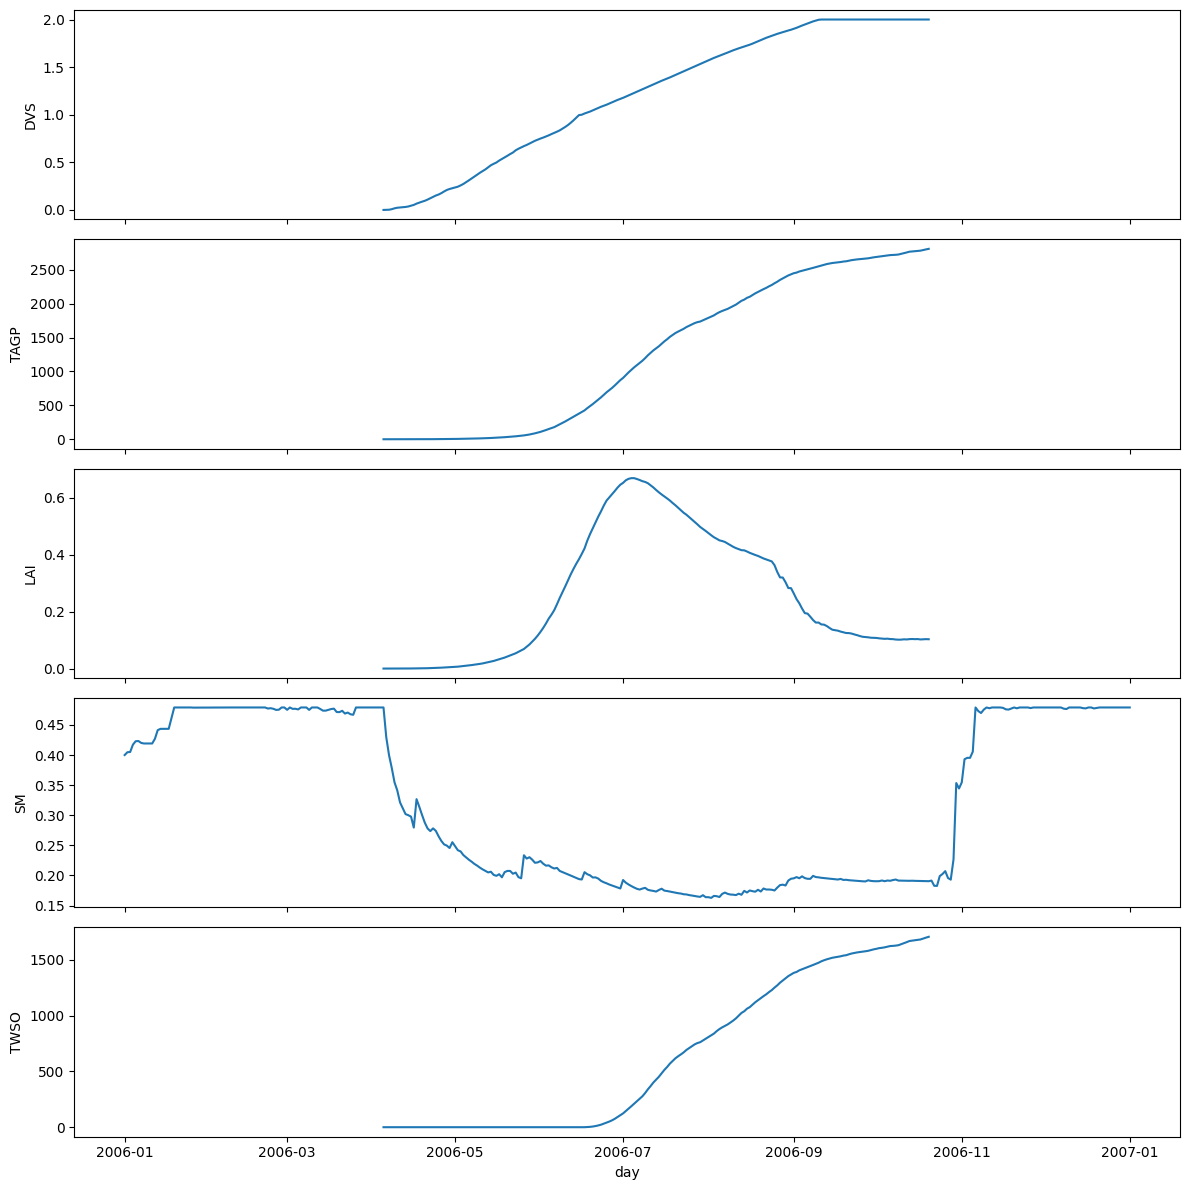

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 12), sharex=True)
axes = axes.flatten()

for i, var in enumerate(['DVS', 'TAGP', 'LAI', 'SM', 'TWSO']):
    sns.lineplot(x=df_results.index, y=df_results[var], ax=axes[i])

plt.tight_layout()
plt.show()